# Seurat integration analysis of human gastrula and PCW3 data

In [1]:
library(Seurat)
library(cowplot)
library(patchwork)
library(SeuratDisk)
library(ggplot2)


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Registered S3 methods overwritten by 'SeuratObject':
  method                     from  
  $.JackStrawData            Seurat
  $.Seurat                   Seurat
  $.SeuratCommand            Seurat
  $<-.Seurat                 Seurat
  [.Assay                    Seurat
  [.DimReduc                 Seurat
  [.Seurat                   Seurat
  [.SeuratCommand            Seurat
  [.SpatialImage             Seurat
  [[.Assay                   Seurat
  [[.DimReduc                Seurat
  [[.Seurat                  Seurat
  levels<-.Seurat            Seurat
  .DollarNames.JackStrawData Seurat
  .DollarNames.Seurat        Seurat
  .DollarNames.SeuratCommand Seurat
  as.list.SeuratCommand      Seurat
  as.logical.JackStrawData   Seurat
  dim.Assay                  Seurat
  dim.DimReduc               Seurat
  dim.Neighbor               Seurat
  dim.Seurat                 Seurat
  dim.Spati

In [2]:
Convert("./data/human_gastrula_pcw3_v1.h5ad",dest='./data/human_gastrula_pcw3_v1.h5Seurat', overwrite = TRUE)

Warning message:
“Unknown file type: h5ad”
Warning message:
“'assay' not set, setting to 'RNA'”
Creating h5Seurat file for version 3.1.5.9900

Adding X as scale.data

Adding X as data

Adding X as counts

Warning message:
“Cannot yet add feature-level metadata from compound datasets”
Warning message:
“No cell-level metadata present, creating fake cell names”
Adding batch_categories to miscellaneous data

Adding cluster_id_categories to miscellaneous data

Adding cluster_id_v1_categories to miscellaneous data

Adding clusters_coarse_categories to miscellaneous data

Adding clusters_coarse_epi_categories to miscellaneous data

Adding clusters_coarse_epi_name_categories to miscellaneous data

Adding clusters_coarse_epi_nname_categories to miscellaneous data

Adding clusters_coarse_nonum_categories to miscellaneous data

Adding louvain2_categories to miscellaneous data

Adding louvain_categories to miscellaneous data

Adding phase_categories to miscellaneous data

Adding sub_cluster_catego

In [3]:
hgw3 <- LoadH5Seurat(file = './data/human_gastrula_pcw3_v1.h5Seurat')

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding scale.data for RNA

Adding feature-level metadata for RNA

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



In [4]:
str(hgw3)

Formal class 'Seurat' [package "Seurat"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "Seurat"] with 8 slots
  .. .. .. ..@ counts       : num [1:16575, 1:13562] 0 0 0 0 0 ...
  .. .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. .. ..$ : chr [1:16575] "A1BG" "A1CF" "A2M" "A2ML1" ...
  .. .. .. .. .. ..$ : chr [1:13562] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. .. .. ..@ data         : num [1:16575, 1:13562] 0 0 0 0 0 ...
  .. .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. .. ..$ : chr [1:16575] "A1BG" "A1CF" "A2M" "A2ML1" ...
  .. .. .. .. .. ..$ : chr [1:13562] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. .. .. ..@ scale.data   : num [1:16575, 1:13562] 0 0 0 0 0 ...
  .. .. .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. .. .. ..$ : chr [1:16575] "A1BG" "A1CF" "A2M" "A2ML1" ...
  .. .. .. .. .. ..$ : chr [1:13562] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. .. .. ..@ key          : chr "rna_"
  .. .. .. ..@ assay.orig   : NULL
  .

In [5]:
metadata=read.csv('./data/human_gastrula_pcw3_metadata_v1.csv')

In [6]:
hgw3@meta.data=metadata

In [7]:
row.names(hgw3@meta.data)=names(Idents(hgw3))

In [8]:
# split the dataset into a list of two seurat objects (stim and CTRL)
hgw3.list <- SplitObject(hgw3, split.by = "batch")

# normalize and identify variable features for each dataset independently
hgw3.list <- lapply(X = hgw3.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures =2000)
})

In [9]:
# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = hgw3.list,nfeatures =2000)

In [10]:
hgw3.anchors <- FindIntegrationAnchors(object.list = hgw3.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4732 anchors

Filtering anchors

	Retained 1518 anchors



In [11]:
# this command creates an 'integrated' data assay
hgw3.combined <- IntegrateData(anchorset = hgw3.anchors)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Adding a command log without an assay associated with it”


In [12]:
# specify that we will perform downstream analysis on the corrected data note that the original
# unmodified data still resides in the 'RNA' assay
DefaultAssay(hgw3.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
hgw3.combined <- ScaleData(hgw3.combined, verbose = FALSE)
hgw3.combined <- RunPCA(hgw3.combined, npcs = 30, verbose = FALSE)
hgw3.combined <- RunUMAP(hgw3.combined, reduction = "pca", dims = 1:30)
hgw3.combined <- FindNeighbors(hgw3.combined, reduction = "pca", dims = 1:30)
hgw3.combined <- FindClusters(hgw3.combined, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:01:29 UMAP embedding parameters a = 0.9922 b = 1.112

17:01:29 Read 13562 rows and found 30 numeric columns

17:01:29 Using Annoy for neighbor search, n_neighbors = 30

17:01:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:01:31 Writing NN index file to temp file /tmp/RtmpWqayWo/file5bad117bae3c4

17:01:31 Searching Annoy index using 1 thread, search_k = 3000

17:01:36 Annoy recall = 100%

17:01:36 Commencing smooth kNN distance calibration using 1 thread

17:01:38 Initializing f

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13562
Number of edges: 464897

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9126
Number of communities: 17
Elapsed time: 1 seconds


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


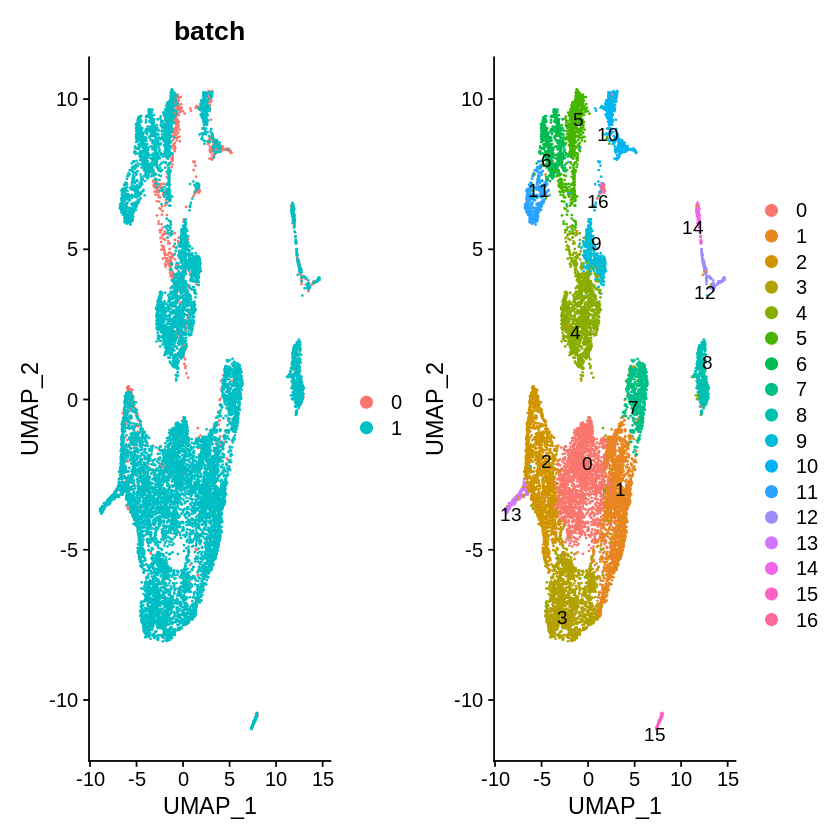

In [13]:
# Visualization
p1 <- DimPlot(hgw3.combined, reduction = "umap", group.by = "batch")
p2 <- DimPlot(hgw3.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

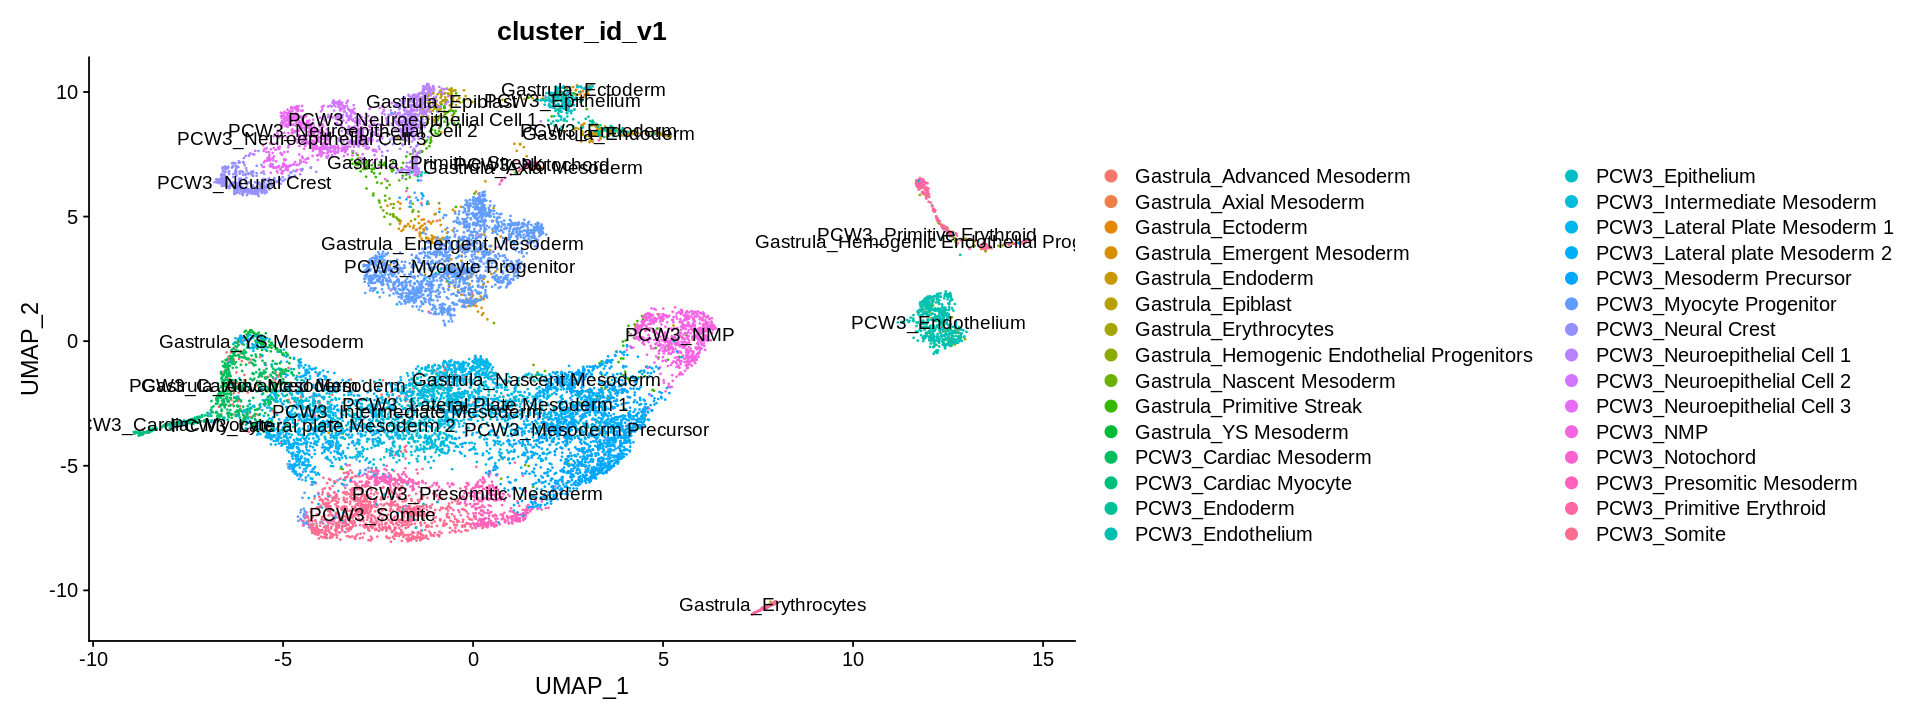

In [14]:
options(repr.plot.width=16, repr.plot.height=6)
p=DimPlot(hgw3.combined, reduction = "umap", group.by = "cluster_id_v1",label=TRUE)
p

17:02:14 UMAP embedding parameters a = 1.262 b = 1.003

17:02:14 Read 13562 rows and found 30 numeric columns

17:02:14 Using Annoy for neighbor search, n_neighbors = 30

17:02:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:02:16 Writing NN index file to temp file /tmp/RtmpWqayWo/file5bad16b9585e2

17:02:16 Searching Annoy index using 1 thread, search_k = 3000

17:02:21 Annoy recall = 100%

17:02:21 Commencing smooth kNN distance calibration using 1 thread

17:02:22 Initializing from normalized Laplacian + noise

17:02:23 Commencing optimization for 200 epochs, with 552784 positive edges

17:02:43 Optimization finished



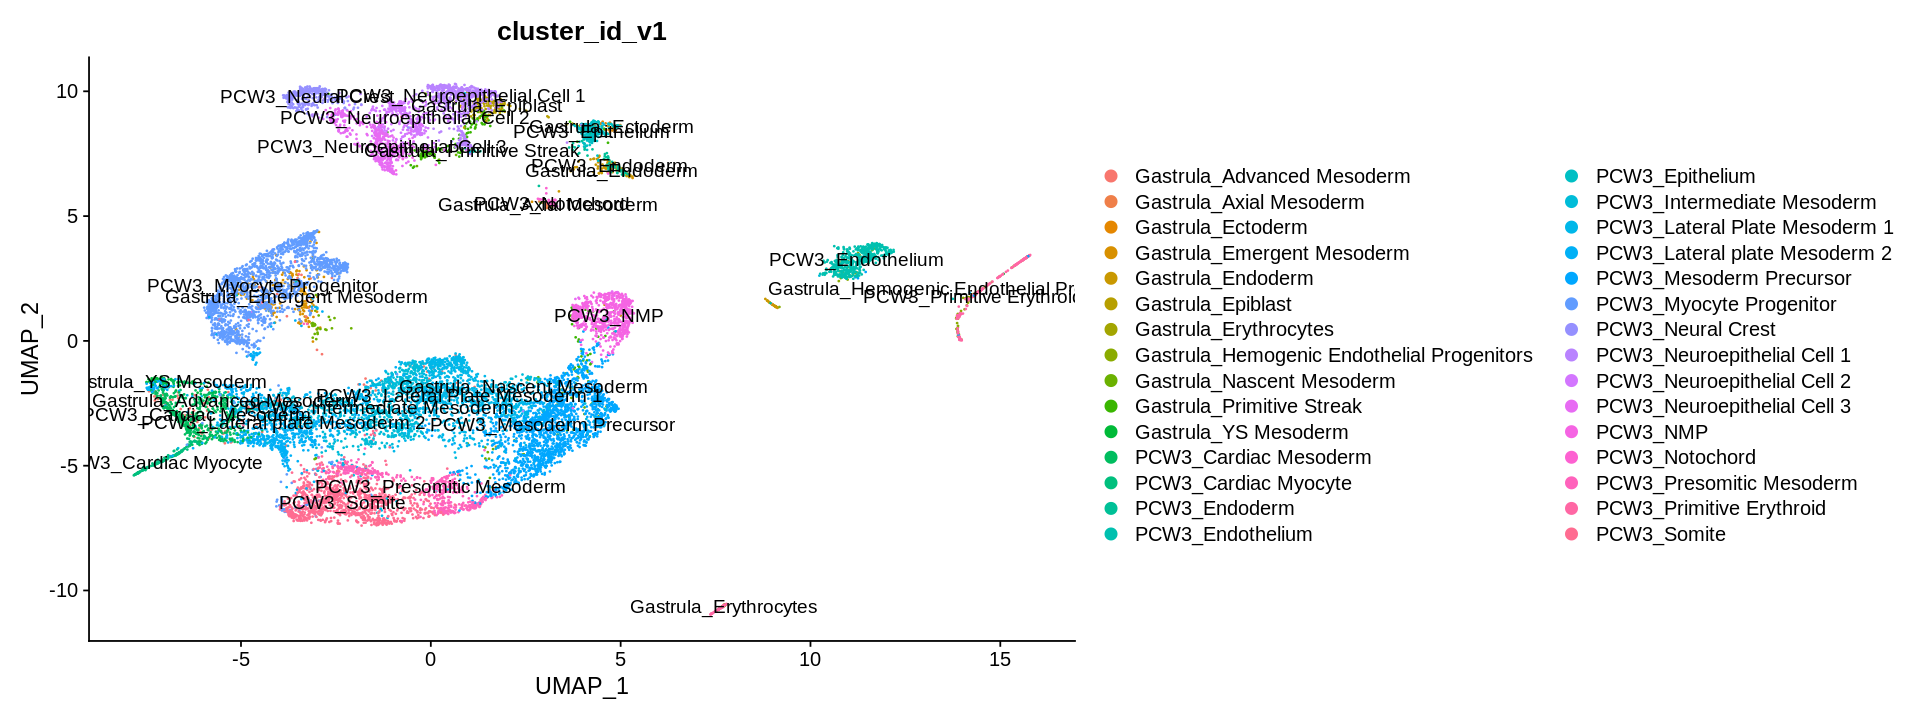

In [15]:
hgw3.combined <- RunPCA(hgw3.combined, npcs = 30, verbose = FALSE)
hgw3.combined <- RunUMAP(hgw3.combined, reduction = "pca", dims = 1:30,min.dist = 0.2)
# hgw3.combined <- FindNeighbors(hgw3.combined, reduction = "pca", dims = 1:50)
options(repr.plot.width=16, repr.plot.height=6)
p=DimPlot(hgw3.combined, reduction = "umap", group.by = "cluster_id_v1",label=TRUE)
p

In [16]:
colors=c('#532C8A', '#c19f70', '#f9decf', '#c9a997', '#B51D8D', '#9e6762', '#3F84AA', '#F397C0', '#C594BF', '#DFCDE4', '#eda450', '#635547', '#C72228', '#EF4E22', '#f77b59', '#989898', '#7F6874', '#8870ad', '#65A83E', '#647a4f', '#EF5A9D', '#FBBE92', '#354E23', '#139992', '#C3C388', '#8EC792', '#0F4A9C', '#8DB5CE', '#1A1A1A', '#FACB12', '#C9EBFB', '#DABE99', '#ed8f84', '#005579', '#CDE088', '#BBDCA8', '#F6BFCB', '#c4a6b2', '#ca728c')

In [17]:
length(colors[1:20])

[1] 20

In [18]:
SaveH5Seurat(hgw3.combined, "./data/CCA_human_gastrula_pcw3.h5Seurat",overwrite = TRUE)

Warning message:
“Overwriting previous file ./data/CCA_human_gastrula_pcw3.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



In [19]:
# save the integrate assay data
Convert("./data/CCA_human_gastrula_pcw3.h5Seurat", dest ="./data/CCA_human_gastrula_pcw3.h5ad",overwrite = TRUE)

Validating h5Seurat file

Adding scale.data from integrated as X

Adding data from integrated as raw

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

Adding integrated_snn as neighbors



In [34]:
# save the RNA assay data
Convert("./data/CCA_human_gastrula_pcw3.h5Seurat", dest ="./data/CCA_human_gastrula_pcw3_assayRNA.h5ad",assay = 'RNA',overwrite = TRUE)

Validating h5Seurat file

Adding data from RNA as X

Adding counts from RNA as raw

Transfering meta.data to obs

Adding dimensional reduction information for umap (global)

